# Machine Learning: Tree-Based Models

**Ziel:** Gradient Boosting Modelle für Zeitreihenvorhersage

**Modelle:**
1. XGBoost
2. LightGBM
3. CatBoost
4. Random Forest (Baseline)

**Basierend auf:** Week04_Trees

**Wichtig:** Feature Engineering ist entscheidend für Performance!

In [3]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from evaluation.metrics import calculate_metrics, print_metrics, compare_models
from visualization.plots import plot_forecast, plot_multiple_forecasts

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✅ Libraries loaded")

ModuleNotFoundError: No module named 'xgboost'

## 1. Daten laden

In [4]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Feature-Spalten (alle außer timestamp und value)
feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'value']]
print(f"\nAnzahl Features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]} ...")

Train: 18262 | Val: 3913 | Test: 3914

Anzahl Features: 31
Features: ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'hour', 'month_sin', 'month_cos'] ...


In [4]:
# Train/Val/Test Arrays vorbereiten
X_train = train_df[feature_cols].values
y_train = train_df['value'].values

X_val = val_df[feature_cols].values
y_val = val_df['value'].values

X_test = test_df[feature_cols].values
y_test = test_df['value'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (18262, 31)
X_test shape: (3914, 31)


## 2. Random Forest (Baseline)

Einfaches Ensemble-Modell als Vergleich

In [5]:
print("Trainiere Random Forest...\n")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_metrics = calculate_metrics(y_test, rf_pred, prefix='test_')
print_metrics(rf_metrics, "Random Forest")

Trainiere Random Forest...



NameError: name 'X_train' is not defined

## 3. XGBoost

Gradient Boosting mit XGBoost

In [6]:
print("Trainiere XGBoost...\n")

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    verbose=0
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_pred = xgb_model.predict(X_test)

xgb_metrics = calculate_metrics(y_test, xgb_pred, prefix='test_')
print_metrics(xgb_metrics, "XGBoost")

print(f"\nBest iteration: {xgb_model.best_iteration}")

Trainiere XGBoost...



NameError: name 'xgb' is not defined

## 4. LightGBM

Schnelles und effizientes Gradient Boosting

In [7]:
print("Trainiere LightGBM...\n")

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

lgb_pred = lgb_model.predict(X_test)

lgb_metrics = calculate_metrics(y_test, lgb_pred, prefix='test_')
print_metrics(lgb_metrics, "LightGBM")

print(f"\nBest iteration: {lgb_model.best_iteration_}")

Trainiere LightGBM...



NameError: name 'lgb' is not defined

## 5. CatBoost

Gradient Boosting optimiert für kategorische Features

In [8]:
print("Trainiere CatBoost...\n")

cb_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3,
    subsample=0.8,
    random_seed=42,
    verbose=0,
    early_stopping_rounds=50
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=False
)

cb_pred = cb_model.predict(X_test)

cb_metrics = calculate_metrics(y_test, cb_pred, prefix='test_')
print_metrics(cb_metrics, "CatBoost")

print(f"\nBest iteration: {cb_model.best_iteration_}")

Trainiere CatBoost...

                          CatBoost                          
  test_mae       :     263.39
  test_rmse      :     379.56
  test_mape      :       3.59%
  test_smape     :       3.55%
  test_r2        :     0.9819
  test_mase      :       0.90

Best iteration: 499


## 6. Modell-Vergleich

In [9]:
all_results = {
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgb_metrics,
    'CatBoost': cb_metrics
}

comparison_df = compare_models(all_results, sort_by='test_rmse')

print("\n" + "=" * 80)
print("TREE-BASED MODELS - COMPARISON")
print("=" * 80)
display(comparison_df.round(2))

best_model = comparison_df['test_rmse'].idxmin()
print(f"\n🏆 Best Model: {best_model}")


TREE-BASED MODELS - COMPARISON


,test_mae,test_rmse,test_mape,test_smape,test_r2,test_mase
LightGBM,246.70,358.81,3.37,3.34,0.98,0.85
XGBoost,246.30,359.46,3.36,3.32,0.98,0.84
Random Forest,244.21,373.58,3.34,3.32,0.98,0.84
CatBoost,263.39,379.56,3.59,3.55,0.98,0.90



🏆 Best Model: LightGBM


## 7. Feature Importance

Welche Features sind am wichtigsten?

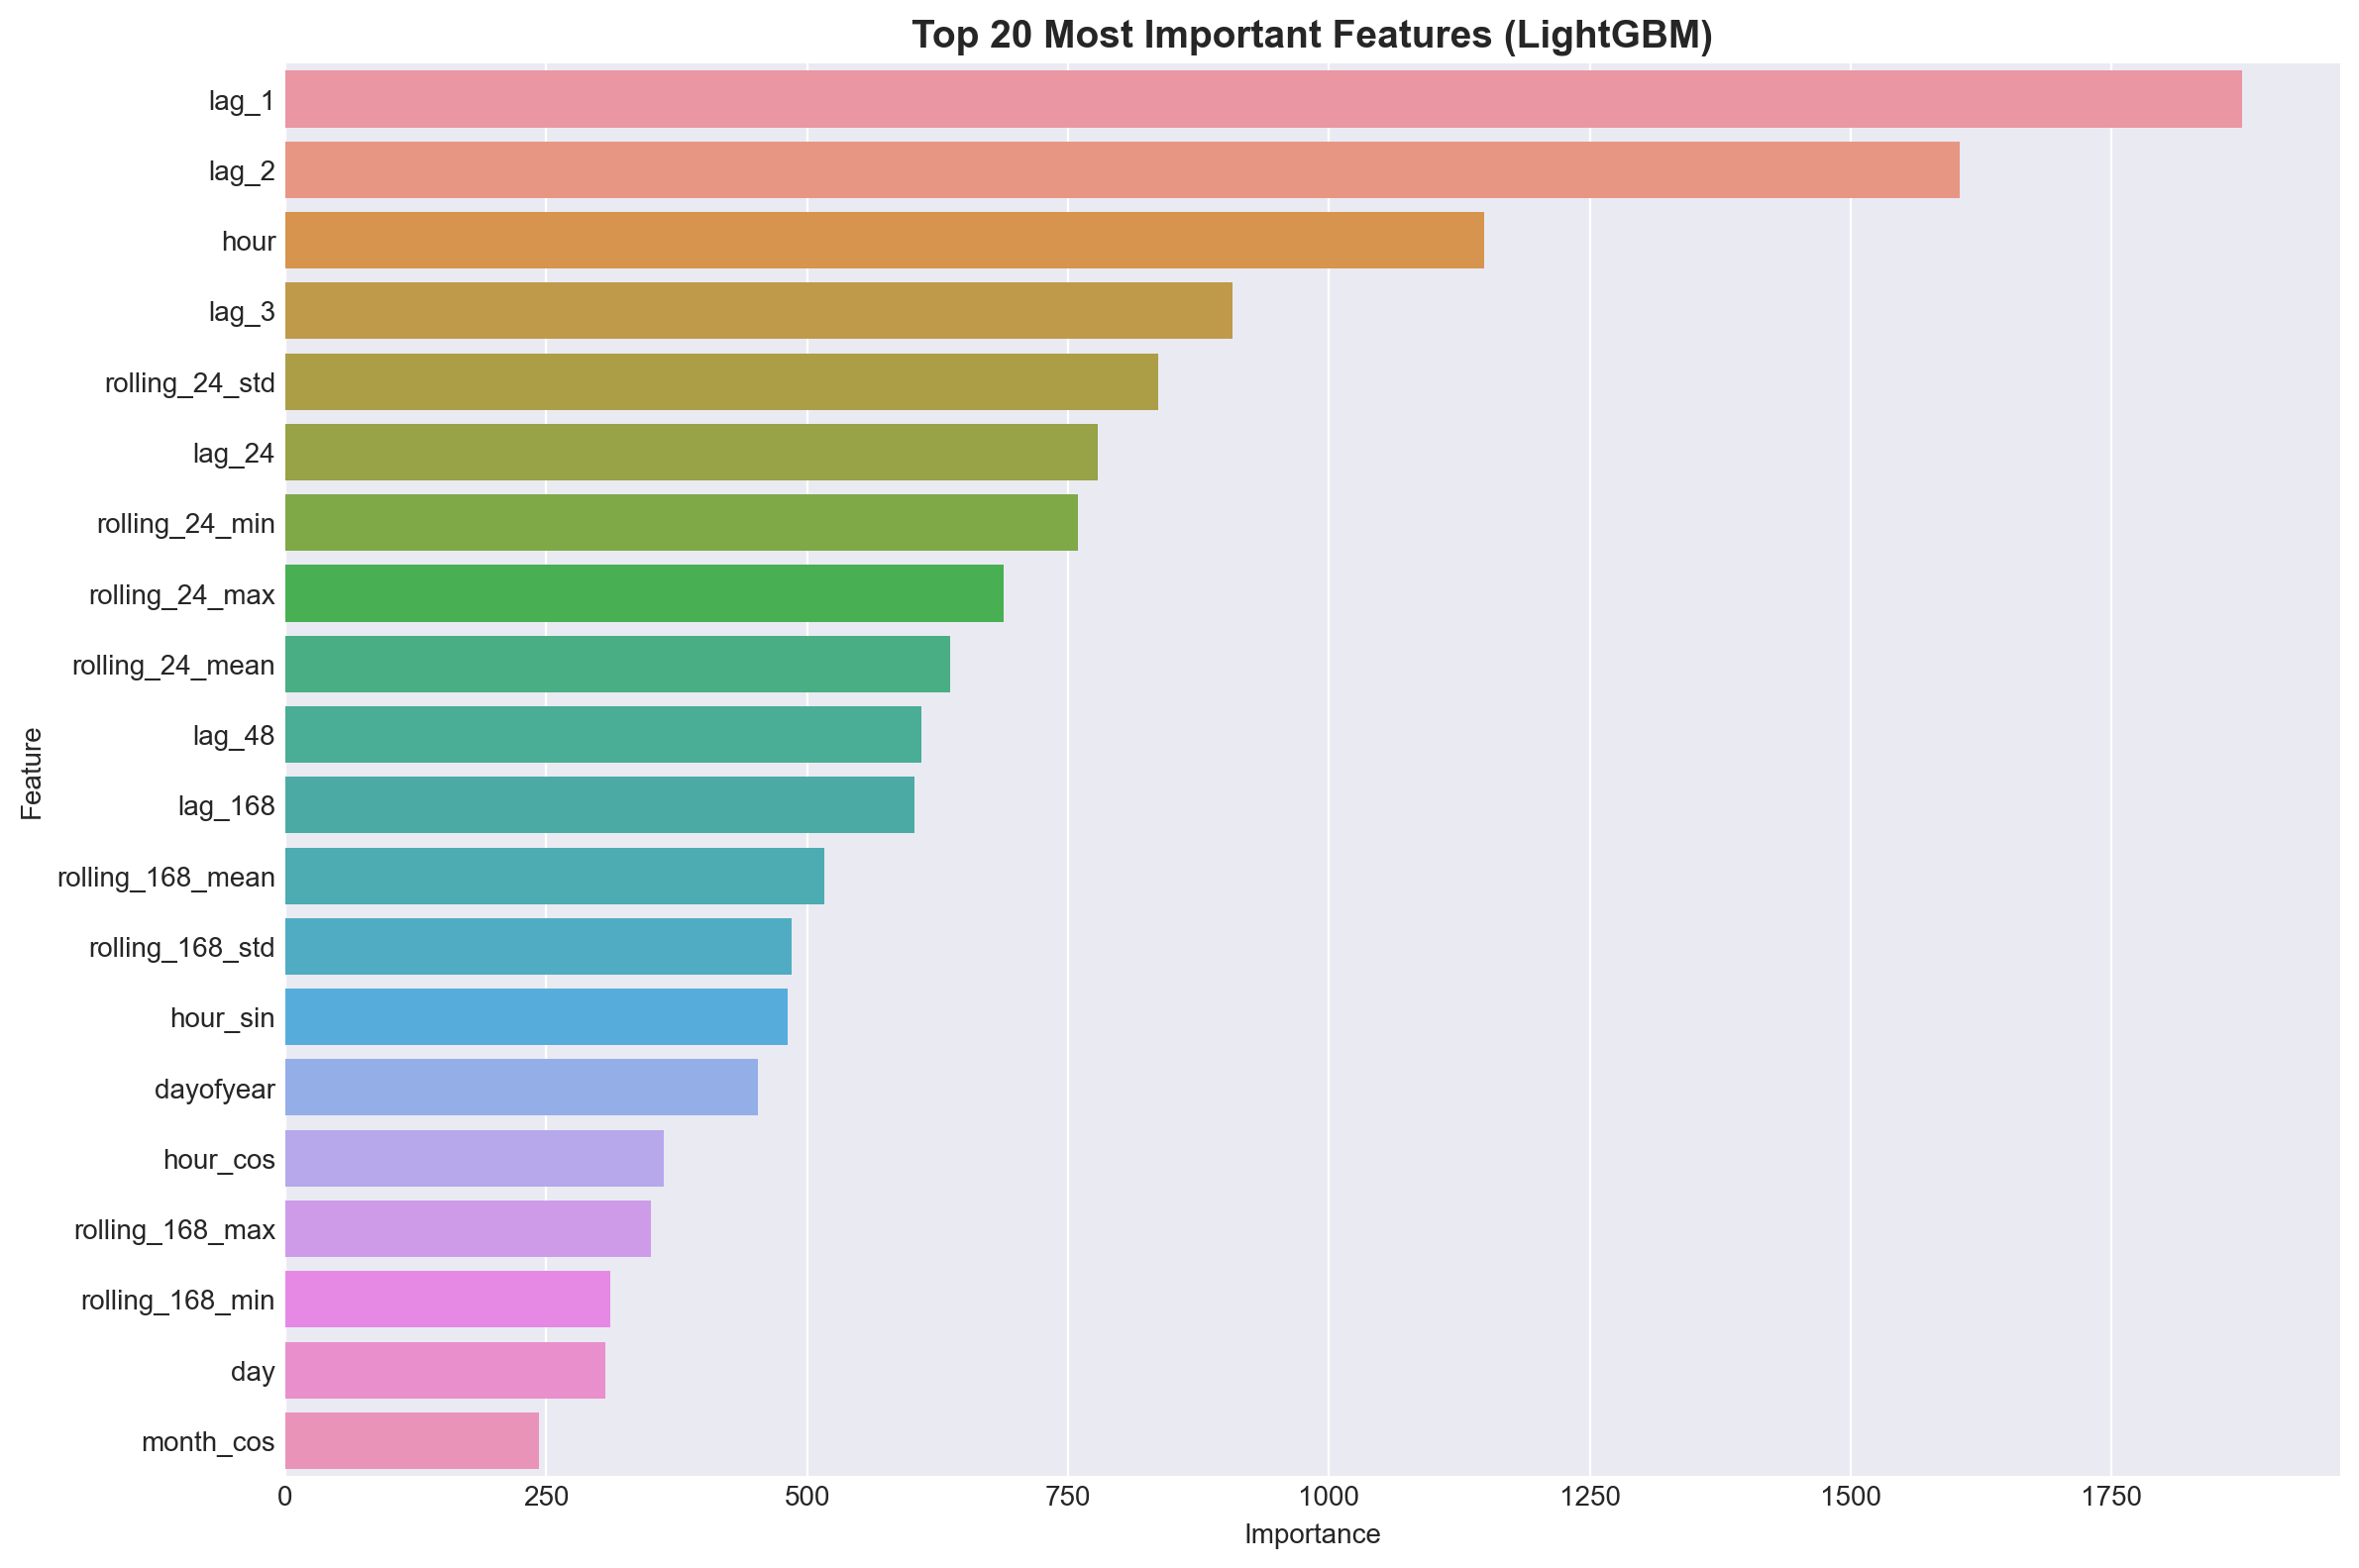


Top 10 Features:


,feature,importance
17,lag_1,1875
18,lag_2,1604
7,hour,1149
19,lag_3,908
24,rolling_24_std,836
20,lag_24,778
25,rolling_24_min,759
26,rolling_24_max,688
23,rolling_24_mean,637
21,lag_48,609


In [10]:
# Feature Importance vom besten Modell (z.B. LightGBM)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 Features
top_n = 20
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=feature_importance.head(top_n),
    y='feature',
    x='importance',
    ax=ax
)

ax.set_title(f'Top {top_n} Most Important Features (LightGBM)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
display(feature_importance.head(10))

## 8. Visualisierung

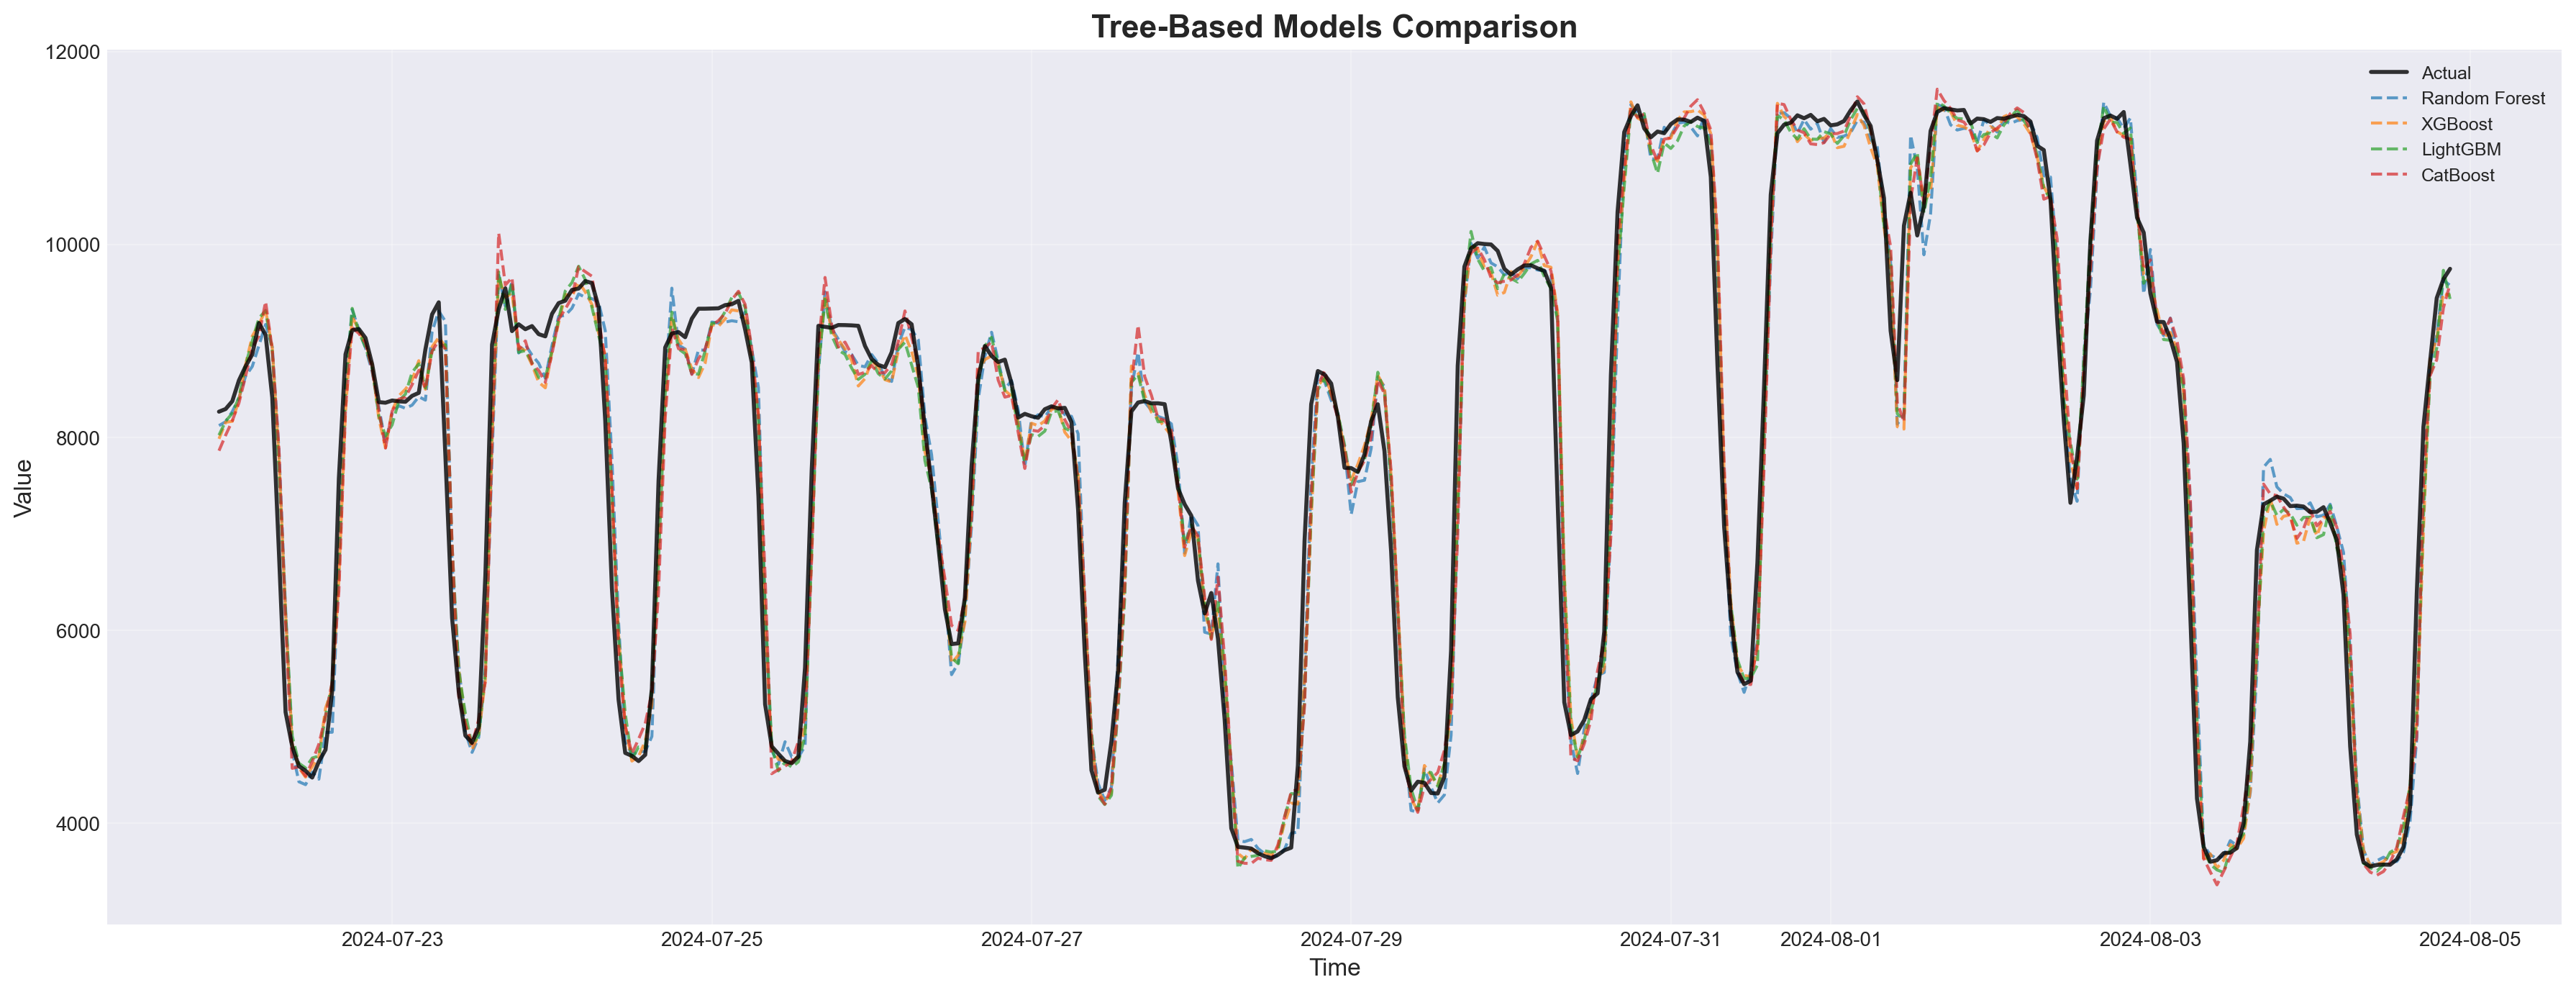

In [11]:
plot_window = 168 * 2  # 2 Wochen

forecasts = {
    'Random Forest': rf_pred[:plot_window],
    'XGBoost': xgb_pred[:plot_window],
    'LightGBM': lgb_pred[:plot_window],
    'CatBoost': cb_pred[:plot_window]
}

plot_multiple_forecasts(
    test_df['timestamp'].iloc[:plot_window],
    y_test[:plot_window],
    forecasts,
    title="Tree-Based Models Comparison",
    figsize=(18, 7)
)

## 9. Hyperparameter Tuning (Optional)

Verwende Optuna für systematische Optimierung

In [12]:
USE_OPTUNA = False  # Setze auf True für Tuning (dauert lange!)

if USE_OPTUNA:
    import optuna
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
        
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        
        rmse = np.sqrt(np.mean((y_val - pred) ** 2))
        return rmse
    
    print("Starte Hyperparameter-Optimierung...\n")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    print(f"\nBeste Parameter: {study.best_params}")
    print(f"Bester RMSE: {study.best_value:.2f}")
else:
    print("ℹ️ Hyperparameter-Tuning übersprungen (USE_OPTUNA=False)")

ℹ️ Hyperparameter-Tuning übersprungen (USE_OPTUNA=False)


## 10. Ergebnisse speichern

In [13]:
results_dir = Path('../results/metrics')
results_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(results_dir / f'{DATA_TYPE}_ml_tree_results.csv')
feature_importance.to_csv(results_dir / f'{DATA_TYPE}_feature_importance.csv', index=False)

print(f"✅ Ergebnisse gespeichert")

✅ Ergebnisse gespeichert


## 11. Zusammenfassung

### Erkenntnisse:

1. **Tree-based Modelle** sind sehr gut für Zeitreihen mit Features
2. **LightGBM** ist oft am schnellsten und performantesten
3. **Feature Engineering** ist entscheidend:
   - Lag-Features wichtig
   - Zeit-Features (Stunde, Tag, Monat)
   - Rolling-Window Features

### Nächste Schritte:

**Deep Learning Models** → `06_deep_learning_models.ipynb`
- LSTM, GRU
- Können sequentielle Muster automatisch lernen